In [1]:
#!pip install tensorflow
#!pip install matplotlib

# Importing The Required Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# Listing All File Paths in the NEU Metal Surface Defects Dataset

In [3]:
for dirname, _, filenames in os.walk(r"F:\Thesis\archive\NEU Metal Surface Defects Data"):
    for filename in filenames:
        print(os.path.join(dirname,filename))

F:\Thesis\archive\NEU Metal Surface Defects Data\Thumbs.db
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_1.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_10.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_100.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_101.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_102.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_103.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_104.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_105.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_106.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_107.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_108.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_109.bmp
F:\Thesis\archive\NEU Metal Surface Defects Data\test\Inclusion\In_1

# Defining Directory Paths for Training, Testing, and Validation Sets

In [4]:
train_dir = r"F:\Thesis\archive\NEU Metal Surface Defects Data\train"
test_dir = r"F:\Thesis\archive\NEU Metal Surface Defects Data\test"
val_dir = r"F:\Thesis\archive\NEU Metal Surface Defects Data\valid"

# Initializing ImageDataGenerators for Data Augmentation and Rescaling
## - `train_datagen` applies both **rescaling and augmentation**.
## - `test_val_datagen` applies **only rescaling**, which is standard for evaluation data.

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
test_val_datagen = ImageDataGenerator(rescale=1./255)



# Creating Data Generators for Training, Validation, and Testing
## - Uses Keras `ImageDataGenerator.flow_from_directory` to load and preprocess images.
## - Applies augmentation and shuffling only to the training set.
## - Keeps validation and test sets fixed (no shuffle) for consistent evaluation.

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='categorical', #categorical means one hot encoded
                                                    shuffle=True)
val_generator = test_val_datagen.flow_from_directory(val_dir,
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='categorical', #categorical means one hot encoded
                                                    shuffle=False)
test_generator = test_val_datagen.flow_from_directory(test_dir,
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='categorical', #categorical means one hot encoded
                                                    shuffle=False)


Found 1464 images belonging to 6 classes.
Found 264 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


# Verifying the Shape of Image and Label Batches from the Training Generator
## - This code retrieves a single batch from `train_generator`.
## - It prints the shape of the image and label arrays.
## - `break` is used to stop after the first batch, making it a quick shape inspection tool.

In [7]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 200, 200, 3)
(32, 6)


# Retrieving and Displaying Class Names from the Training Generator
## - `train_generator.class_indices` provides a dictionary mapping class names to numeric labels.
## - `list(class_names.keys())` extracts just the class names.
## - `print(class_names_list)` outputs the list of class names in the training data.

In [8]:
class_names = train_generator.class_indices
class_names_list = list(class_names.keys())
print(class_names_list)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


# Visualizing Sample Images from the Training Generator with Their Class Labels
## - The function retrieves one image and its label from the generator using `next()`.
## - It uses `matplotlib` to plot a grid of sample images.
## - Class labels are derived using `np.argmax` and shown as titles.

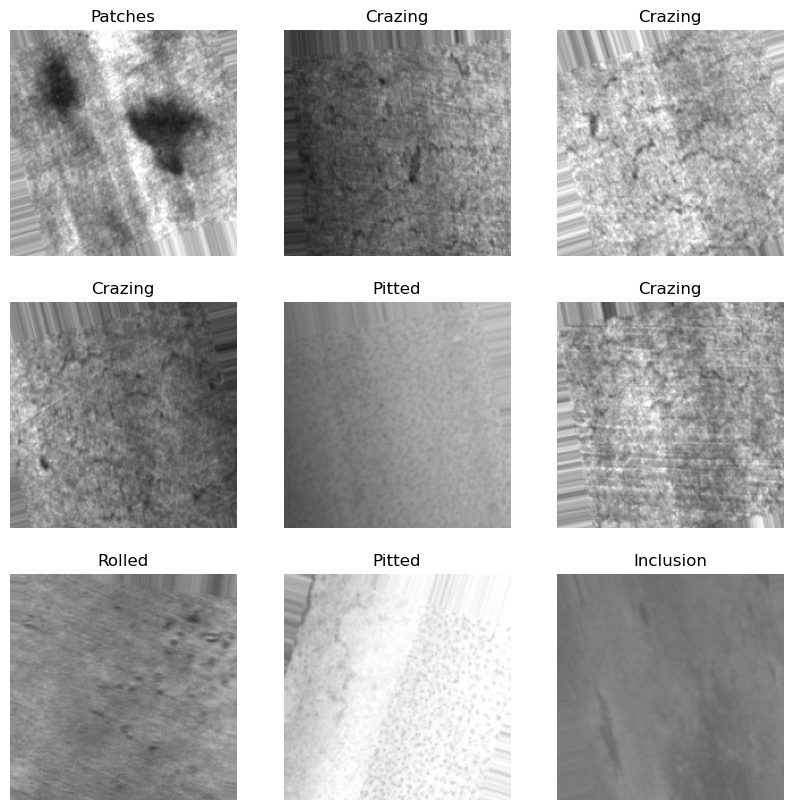

In [9]:
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names_list[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    
    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

sample_images(train_generator, nrows=3, ncols=3)


# Function For Plotting Training and Validation Metrics Over Epochs

In [10]:
def plot_history(history,metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric],"")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])
    plt.show()

# Defining a Custom Convolutional Neural Network Model (Model 1)
## - Constructs a CNN with four convolutional + max-pooling blocks increasing in filter size from 32 to 256.

## - Applies batch normalization, ReLU activation, and dropout for regularization before the output layer.

## - Outputs a softmax layer with 6 units for multi-class classification (6 classes).

## - Returns the compiled model ready for training.

In [11]:
def load_model_1():
    model = Sequential([ 
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
                         
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
                         
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
                         
    Flatten(),    
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')])

    return model

# Compiling and Training the Custom CNN Model with Learning Rate Scheduling
## - Uses default Adam optimizer in compile().

## - Defines two LR schedulers but applies only the one that monitors validation loss (val_loss).

## - Trains for 30 epochs with validation data and reduces LR on plateau of validation loss.

In [12]:
optimizer = Adam(learning_rate=1e-4)
lr_scheduler_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
lr_scheduler_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1)

cnn_model = load_model_1()
cnn_model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])

history_model1 = cnn_model.fit(
                        train_generator, 
                        epochs=30, 
                        validation_data=val_generator, 
                        callbacks= [
                            #lr_scheduler_acc,
                            lr_scheduler_loss
                        ])
                              

C:\Users\asus\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\asus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 832ms/step - accuracy: 0.4703 - loss: 1.4603 - val_accuracy: 0.1667 - val_loss: 12.0594 - learning_rate: 0.0010
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 523ms/step - accuracy: 0.8018 - loss: 0.5778 - val_accuracy: 0.1667 - val_loss: 10.2141 - learning_rate: 0.0010
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 522ms/step - accuracy: 0.8242 - loss: 0.4957 - val_accuracy: 0.3788 - val_loss: 6.7989 - learning_rate: 0.0010
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 536ms/step - accuracy: 0.8710 - loss: 0.4067 - val_accuracy: 0.1818 - val_loss: 4.6034 - learning_rate: 0.0010
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 520ms/step - accuracy: 0.8690 - loss: 0.3789 - val_accuracy: 0.3182 - val_loss: 2.5556 - learning_rate: 0.0010
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 521ms/step - accuracy: 0.9045 - loss: 0.2994 - val_accuracy: 0.5455 - val_loss: 1.4798 - learning_rate: 0.0010
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 534ms/step - accuracy: 0.8864 - loss: 

# Evaluating the CNN Model on the Test Set and Plotting Training History
## - Evaluates the trained CNN model on the test dataset generator, returning loss and accuracy.

## - Prints both the overall test loss and test accuracy separately.

## - Plots the training and validation accuracy and loss curves over epochs using the previously defined plot_history function.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9388 - loss: 0.1394
Test loss, Test accuracy :  [0.16495244204998016, 0.9166666865348816]
Test accuracy: 0.9166666865348816


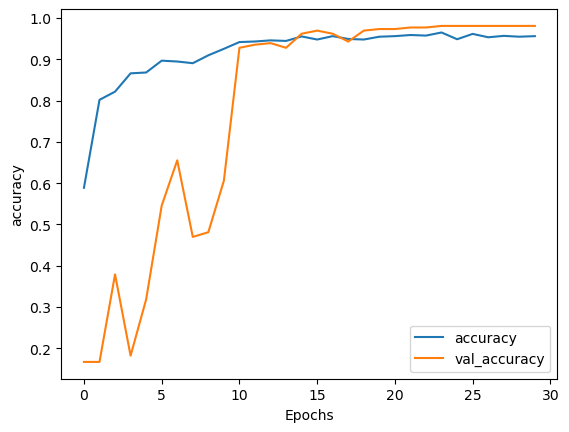

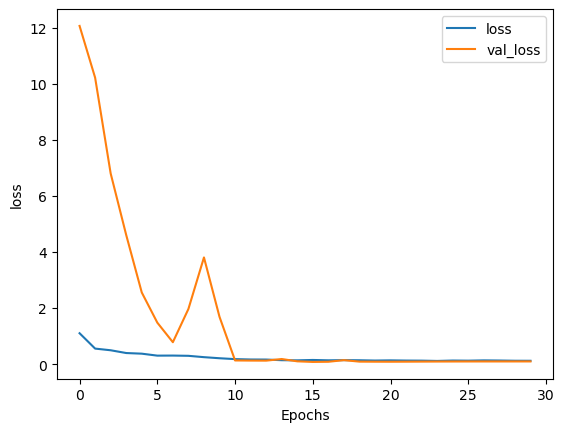

In [13]:
result = cnn_model.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)
print("Test accuracy:", result[1])

plot_history(history_model1,"accuracy")
plot_history(history_model1,"loss")

# Generating Predictions and Extracting True Labels from the Test Set
## - Uses the trained CNN model to predict class probabilities on the test dataset.

## - Converts these probabilities to discrete class labels by selecting the class with highest predicted probability.

## - Accesses the true class labels provided by the test data generator for further evaluation (e.g., confusion matrix, accuracy).

In [14]:
# Get model predictions
pred_probs_cnn = cnn_model.predict(test_generator)
pred_labels = np.argmax(pred_probs_cnn, axis=1)

# Get true labels
true_labels = test_generator.classes


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


# Creating and Visualizing the Confusion Matrix for the Baseline CNN Model
## - Computes the confusion matrix comparing true and predicted labels.

## - Extracts class names from the test data generator for labeling the matrix.

## - Displays a color-coded confusion matrix plot with rotated x-axis labels and a descriptive title.

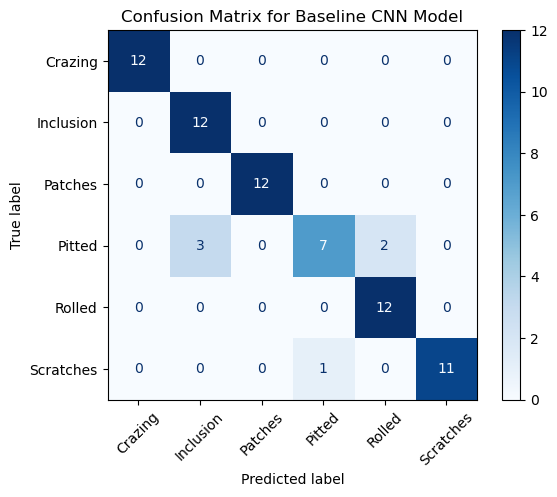

In [15]:
# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Optional: class names (from generator)
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Baseline CNN Model")
plt.show()


# Saving the Trained CNN Model to Disk

In [16]:
cnn_model.save("cnn_model1.h5")

# Defining a Transfer Learning Model Based on VGG16
## - Loads the pre-trained VGG16 convolutional base without the top classification layers (include_top=False).

## - Builds a new sequential model by adding the base model, followed by flattening, a dense hidden layer with ReLU activation, dropout for regularization, and a softmax output layer for 6 classes.

## - Prepares the model for training on your custom dataset with transfer learning.

In [17]:
def load_model_2(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(6, activation='softmax'))
    return model

# Compiling the VGG16-based Model with Learning Rate Scheduling Callbacks
## - Initializes the Adam optimizer with a learning rate of 0.0003.
## - Loads and compiles the VGG16 transfer learning model for multi-class classification with categorical cross-entropy loss and accuracy metric.
## - Defines two learning rate scheduler callbacks to reduce the learning rate by half when validation loss or accuracy plateaus for 2 epochs.

In [18]:
optimizer = Adam(learning_rate=3e-4)
vgg_model = load_model_2((200, 200, 3))  
vgg_model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
lr_scheduler_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)


# Training the VGG16 Model with Learning Rate Scheduling Callback
## - Trains the VGG16-based model on the training data generator for 30 epochs.
## - Validates performance on the validation data generator each epoch.
## - Uses a learning rate scheduler callback monitoring validation loss to reduce learning rate when needed.

In [19]:
history_model2 = vgg_model.fit(train_generator, 
                               epochs=30, 
                               validation_data=val_generator,
                               callbacks=[
                                   #lr_scheduler_acc,
                                   lr_scheduler_loss
                               ],
                              )

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 325s 7s/step - accuracy: 0.1594 - loss: 2.3016 - val_accuracy: 0.1667 - val_loss: 1.7845 - learning_rate: 0.0010
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 323s 7s/step - accuracy: 0.2106 - loss: 1.8165 - val_accuracy: 0.3295 - val_loss: 1.5503 - learning_rate: 0.0010
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step - accuracy: 0.3764 - loss: 1.4347 - val_accuracy: 0.6439 - val_loss: 0.9060 - learning_rate: 0.0010
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step - accuracy: 0.6128 - loss: 0.9764 - val_accuracy: 0.7197 - val_loss: 0.6761 - learning_rate: 0.0010
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step - accuracy: 0.6589 - loss: 0.9224 - val_accuracy: 0.6477 - val_loss: 1.0227 - learning_rate: 0.0010
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6356 - loss: 0.9110
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
46/46 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step - accuracy: 0.6364 - loss: 0.9091 - val_accura

# Evaluating the VGG16 Model on Test Data and Plotting Training History
## - Evaluates the trained VGG16 model on the test dataset, printing both test loss and accuracy.
## - Uses the plot_history function to visualize the training and validation accuracy and loss across epochs.

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 930ms/step - accuracy: 0.9310 - loss: 0.1491
Test loss, Test accuracy :  [0.21069404482841492, 0.9166666865348816]
Test accuracy: 0.9166666865348816


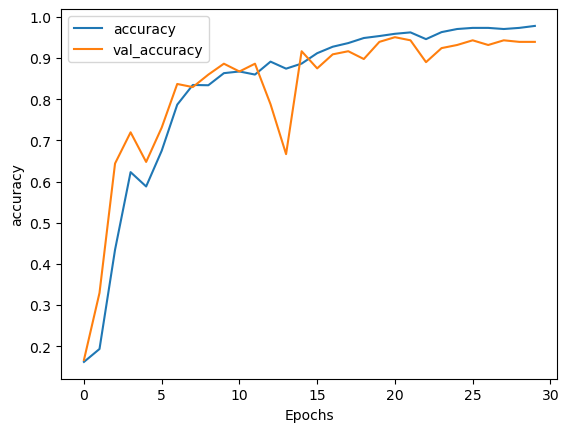

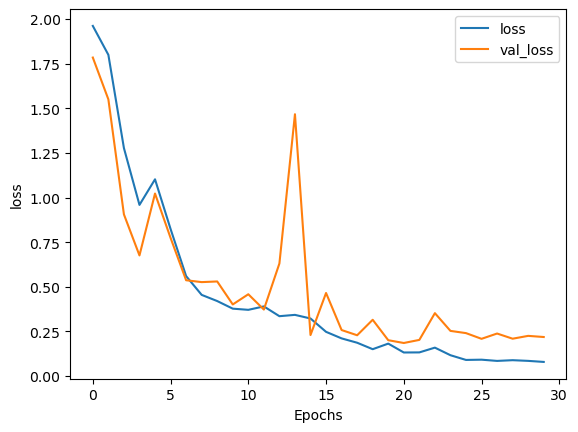

In [20]:
result2= vgg_model.evaluate(test_generator)
print("Test loss, Test accuracy : ", result2)
print("Test accuracy:", result2[1])

plot_history(history_model2,'accuracy')
plot_history(history_model2,'loss')

# Generating Predictions and Extracting True Labels for the VGG16 Model
## - Obtains predicted probabilities from the trained VGG16 model on the test dataset.
## - Converts these probabilities into discrete predicted class labels using argmax.
## - Retrieves the actual labels from the test generator for performance evaluation.

In [21]:
# Get model predictions
pred_probs_vgg = vgg_model.predict(test_generator)
pred_labels_vgg = np.argmax(pred_probs_vgg, axis=1)

# Get true labels
true_labels = test_generator.classes

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


# Creating and Visualizing the Confusion Matrix for the VGG16 Model
## - Computes the confusion matrix comparing true and predicted labels from the VGG16 model.
## - Extracts class names for labeling the confusion matrix.
## - Displays a color-coded confusion matrix plot with rotated x-axis labels and a descriptive title.

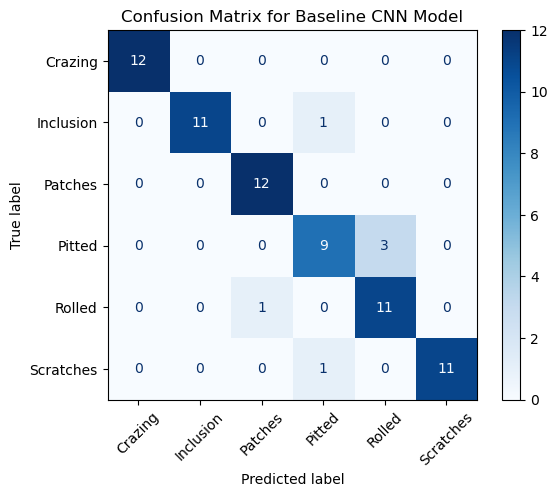

In [22]:
# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels_vgg)

# Optional: class names (from generator)
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Baseline CNN Model")
plt.show()

# Saving the Trained VGG16 Model to Disk

In [23]:
vgg_model.save("vgg_model.h5")

# Defining, Compiling, and Training a Transfer Learning Model Based on ResNet50
## - Loads the ResNet50 pretrained base without the top classification layers.
## - Builds a sequential model adding flattening, a dense hidden layer, dropout, and a final softmax output for 6 classes.
## - Optionally allows freezing early layers for transfer learning.
## - Uses Adam optimizer with categorical cross-entropy loss and accuracy metric.
## - Trains the model for 30 epochs with a learning rate scheduler callback monitoring validation loss.

In [24]:
def load_model_3(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    #for layer in base_model.layers[:10]:
     #   layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))#, kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    #model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
    #model.add(Dropout(0.3))
    model.add(Dense(6, activation='softmax'))#, kernel_regularizer=l2(0.0001)))
    return model


#optimizer= Adam(learning_rate=0.0005)
lr_scheduler_loss= ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
lr_scheduler_acc= ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1)

resnet_model = load_model_3((200, 200, 3))  # Adjust input shape as per your dataset
resnet_model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_model3 = resnet_model.fit(train_generator, 
                                  epochs=30, 
                                  validation_data=val_generator,
                                  callbacks=[
                                              lr_scheduler_loss, 
                                              #lr_scheduler_acc,
                                            ],
                                 )


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 268s 5s/step - accuracy: 0.6167 - loss: 13.3297 - val_accuracy: 0.1667 - val_loss: 7355.9004 - learning_rate: 0.0010
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 243s 5s/step - accuracy: 0.8626 - loss: 0.6546 - val_accuracy: 0.1667 - val_loss: 2732.9087 - learning_rate: 0.0010
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.8995 - loss: 0.3755 - val_accuracy: 0.1667 - val_loss: 298.7654 - learning_rate: 0.0010
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step - accuracy: 0.9495 - loss: 0.1990 - val_accuracy: 0.1667 - val_loss: 10.0141 - learning_rate: 0.0010
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 271s 6s/step - accuracy: 0.9067 - loss: 0.3807 - val_accuracy: 0.1667 - val_loss: 403293.2812 - learning_rate: 0.0010
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 265s 6s/step - accuracy: 0.9018 - loss: 0.4652 - val_accuracy: 0.1667 - val_loss: 1.7920 - learning_rate: 0.0010
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 245s 5s/step - accuracy: 0.9417 - loss: 0

# Evaluating the ResNet50 Model on Test Data and Plotting Training History
## - Evaluates the trained ResNet50 model on the test dataset, printing the loss and accuracy.
## - Uses the plot_history function to visualize training and validation accuracy and loss over epochs.

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step - accuracy: 0.9783 - loss: 0.0407
Test loss, Test accuracy :  [0.0434277281165123, 0.9722222089767456]
Test accuracy: 0.9722222089767456


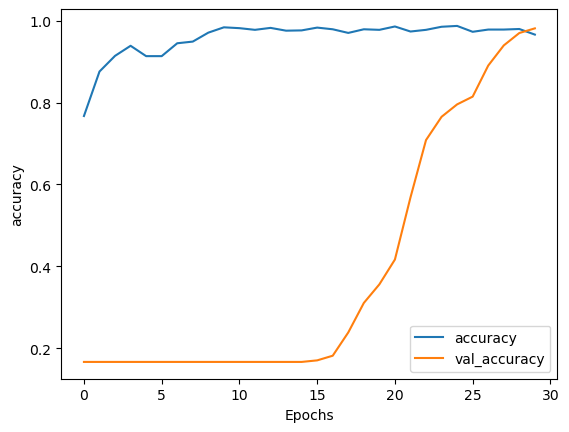

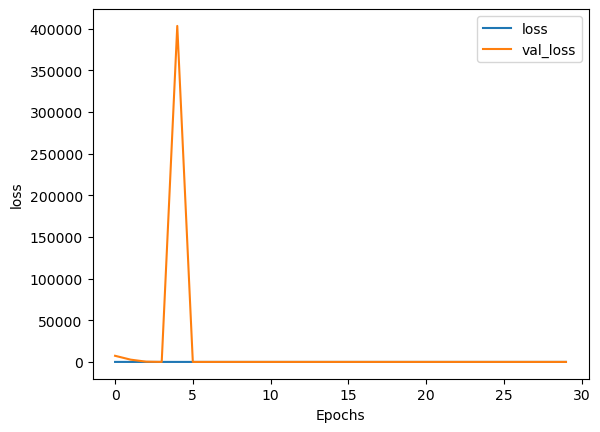

In [41]:
result3= resnet_model.evaluate(test_generator)
print("Test loss, Test accuracy : ", result3)
print("Test accuracy:", result3[1])


plot_history(history_model3,'accuracy')
plot_history(history_model3, 'loss')

In [42]:
#result = resnet_model.evaluate(test_generator, steps=len(test_generator), verbose=1)


# Generating Predictions and Extracting True Labels for the ResNet50 Model
## - Obtains predicted probabilities from the trained ResNet50 model on the test dataset.
## - Converts probabilities into predicted class indices using argmax.
## - Retrieves the true labels from the test generator for evaluation purposes.

In [43]:
# Get model predictions
pred_probs_res = resnet_model.predict(test_generator)
pred_labels_res = np.argmax(pred_probs_res, axis=1)

# Get true labels
true_labels = test_generator.classes

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step


# Creating and Visualizing the Confusion Matrix for the ResNet50 Model
## - Computes the confusion matrix comparing true and predicted labels from the ResNet50 model.
## - Extracts class names from the test generator for labeling the matrix.
## - Displays a color-coded confusion matrix with rotated x-axis labels and a title.

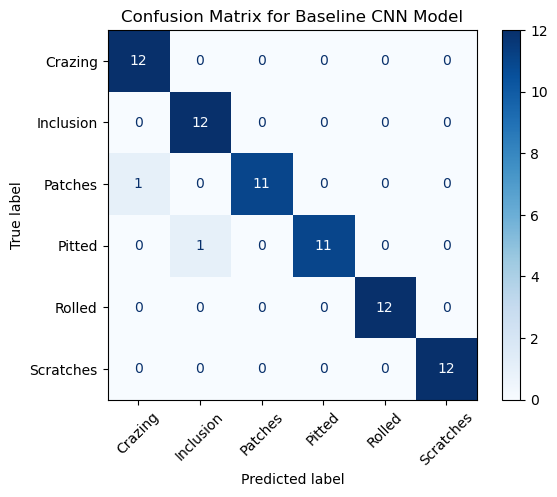

In [44]:
# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels_res)

# Optional: class names (from generator)
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Baseline CNN Model")
plt.show()

# Saving the Trained ResNet50 Model to Disk

In [45]:
resnet_model.save('resnet_model.h5')

# Comparing Training Accuracy and Loss Across All Models
## - Plots the training accuracy curves of three models side-by-side for easy comparison.
## - Plots the training loss curves of the same models in parallel.
## - Uses Matplotlib subplots for visual clarity with legends and axis labels.

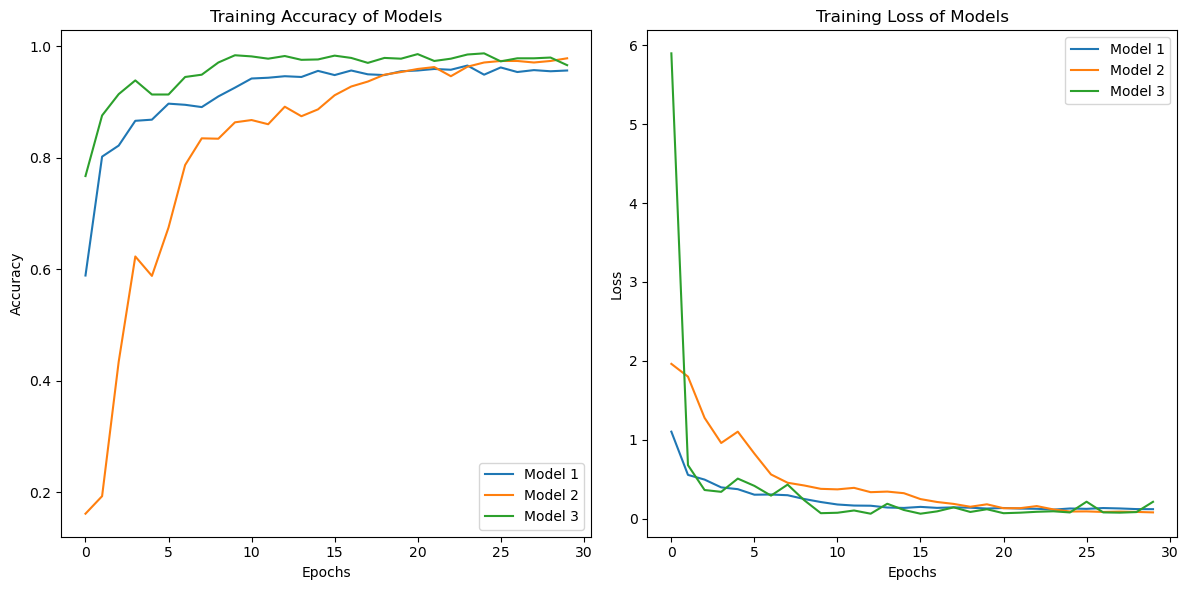

In [30]:
import matplotlib.pyplot as plt

# Assuming you have access to the training history of each model
# history_model1, history_model2, history_model3 represent the training history of each respective model

# Plotting accuracy for all models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_model1.history['accuracy'], label='Model 1')
plt.plot(history_model2.history['accuracy'], label='Model 2')
plt.plot(history_model3.history['accuracy'], label='Model 3')
plt.title('Training Accuracy of Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss for all models
plt.subplot(1, 2, 2)
plt.plot(history_model1.history['loss'], label='Model 1')
plt.plot(history_model2.history['loss'], label='Model 2')
plt.plot(history_model3.history['loss'], label='Model 3')
plt.title('Training Loss of Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Loading Saved CNN, VGG16, and ResNet50 Models from Disk

In [11]:
cnn_model = load_model("cnn_model1.h5")
vgg_model = load_model("vgg_model.h5")
resnet_model = load_model("resnet_model.h5")

# Comparing Accuracy and Loss of CNN, VGG16, and ResNet Models on Validation/Test Set
## - Evaluates each of the three models on a common validation or test set.
## - Collects the accuracy and loss from each evaluation.
## - Visualizes the comparative accuracy and loss using bar charts for easy model performance comparison.

C:\Users\asus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.9823 - loss: 0.0981
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9667 - loss: 0.1180
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 906ms/step - accuracy: 0.9762 - loss: 0.0474


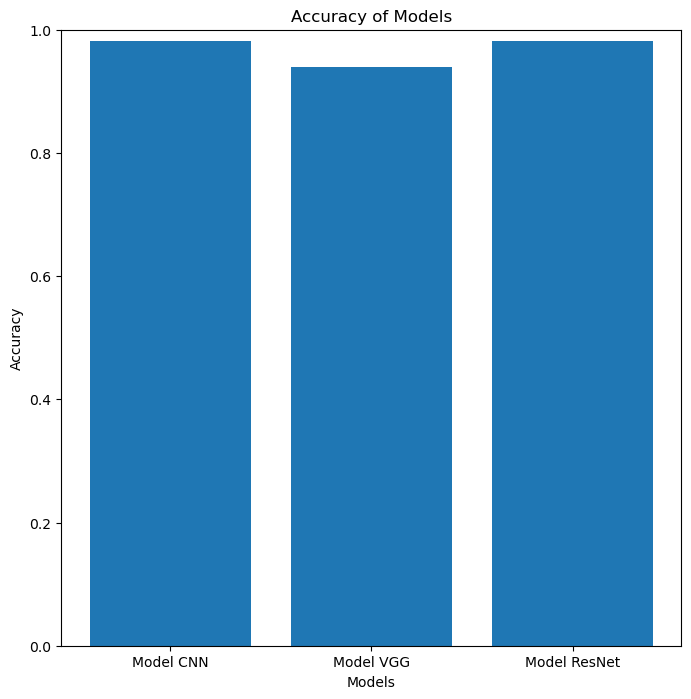

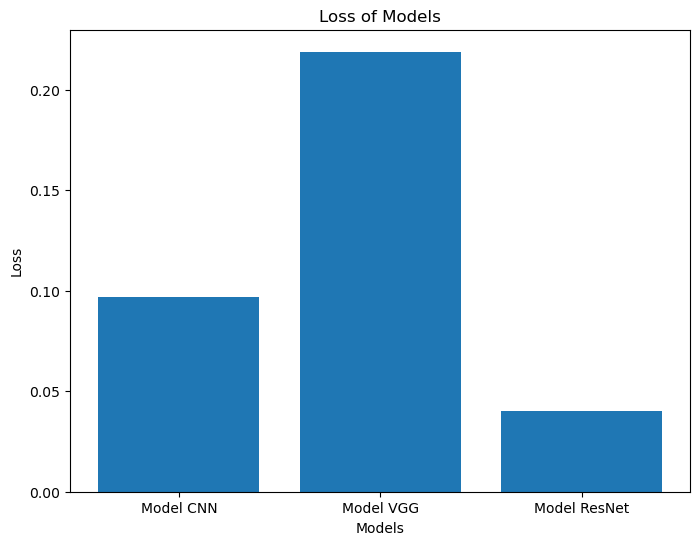

In [12]:
# Lists to store accuracy and loss values for each model
accuracy_values = []
loss_values = []

# Evaluate each model on the validation or test set
models = [cnn_model, vgg_model, resnet_model]  # Replace with your models
for model in models:
    # Evaluate the model on the validation or test set
    evaluation = model.evaluate(val_generator)  # Replace with your validation or test set
    accuracy_values.append(evaluation[1])  # Assuming accuracy is at index 1
    loss_values.append(evaluation[0])  # Assuming loss is at index 0

# Plotting accuracy for all models
plt.figure(figsize=(8, 8))
plt.bar(np.arange(len(models)), accuracy_values, tick_label=['Model CNN', 'Model VGG', 'Model ResNet'])
plt.title('Accuracy of Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to represent accuracy values (0 to 1)
plt.show()

# Plotting loss for all models
plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(models)), loss_values, tick_label=['Model CNN', 'Model VGG', 'Model ResNet'])
plt.title('Loss of Models')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.show()

# Generating Predictions and Evaluating an Ensemble Model Using Weighted Averaging
## - Obtains predicted class probabilities from three separate models.
## - Combines these predictions via a weighted average ensemble method, prioritizing the best-performing model.
## - Converts the ensemble probabilities to final predicted classes.
## - Calculates and prints the overall ensemble accuracy on the test set.

In [13]:
# Generate predictions from refined models
preds_model1 = cnn_model.predict(test_generator)
preds_model2 = vgg_model.predict(test_generator)
preds_model3 = resnet_model.predict(test_generator)

# Ensemble method: weighted averaging predictions
# Adjust weights according to the model performance on validation data
ensemble_preds = (0.1 * preds_model1 + 0.1 * preds_model2 + 0.8 * preds_model3) / 3

# Evaluate ensemble performance
ensemble_result = accuracy_score(test_generator.classes, np.argmax(ensemble_preds, axis=1))
print("Ensemble Accuracy on Test Set:", ensemble_result)

C:\Users\asus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 992ms/step


2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E954BDEAC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Ensemble Accuracy on Test Set: 0.9861111111111112


# Comparing Individual Model Accuracies with the Ensemble Accuracy
## - Computes classification accuracies for each individual model on the test set.
## - Plots a bar chart showing accuracies of each model side-by-side.
## - Highlights the ensemble’s accuracy with a distinct color for easy comparison.

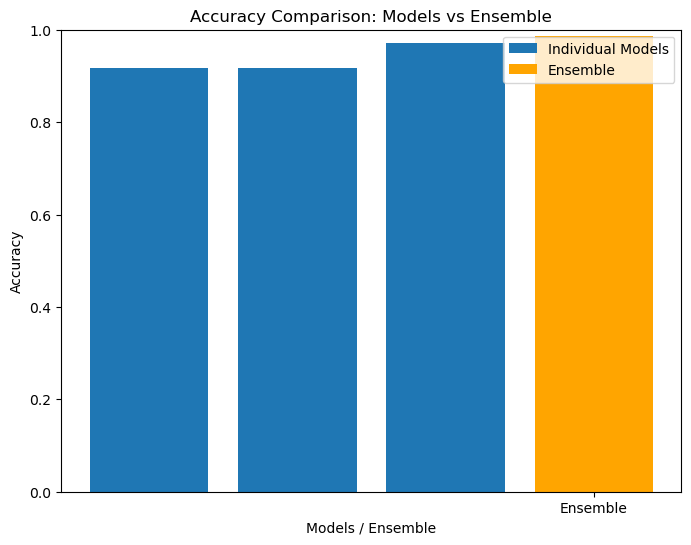

In [14]:

# Calculate accuracies for individual models
accuracy_model1 = accuracy_score(test_generator.classes, np.argmax(preds_model1, axis=1))
accuracy_model2 = accuracy_score(test_generator.classes, np.argmax(preds_model2, axis=1))
accuracy_model3 = accuracy_score(test_generator.classes, np.argmax(preds_model3, axis=1))

# Plotting accuracies
plt.figure(figsize=(8, 6))

# Plot individual model accuracies
plt.bar([1, 2, 3], [accuracy_model1, accuracy_model2, accuracy_model3], tick_label=['Model CNN', 'Model VGG', 'Model ResNet'], label='Individual Models')
# Plot ensemble accuracy
plt.bar(4, ensemble_result, tick_label=['Ensemble'], label='Ensemble', color='orange')

plt.title('Accuracy Comparison: Models vs Ensemble')
plt.xlabel('Models / Ensemble')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to represent accuracy values (0 to 1)
plt.legend()
plt.show()

# Implementing a Stacked Ensemble with Logistic Regression as Meta-Classifier
## - Extracts prediction probabilities from three base models on the validation set and horizontally stacks them as features.
## - Trains a Logistic Regression model as a meta-classifier on these stacked predictions with true labels from validation data.
## - Uses the meta-classifier to predict final labels on the test set by stacking test predictions similarly.
## - Evaluates ensemble accuracy and displays a confusion matrix for model performance visualization.
## - Calculates and prints macro-averaged precision, recall, F1-score, and a detailed classification report for the ensemble model.

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 885ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 889ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 642ms/step
Stacked Ensemble Accuracy on Test Set: 0.9861111111111112
Confusion Matrix:
 [[12  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  1  0 11]]


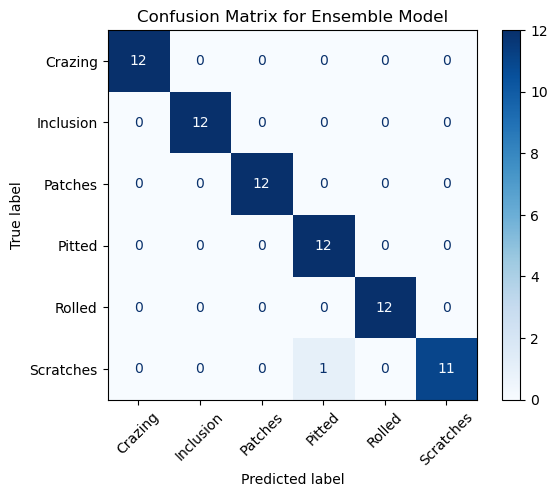

Precision: 0.99
Recall: 0.99
F1-Score: 0.99

Classification Report:
               precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       1.00      1.00      1.00        12
     Patches       1.00      1.00      1.00        12
      Pitted       0.92      1.00      0.96        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      0.92      0.96        12

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



In [53]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions from each base model on validation set
preds_cnn_val = cnn_model.predict(val_generator)
preds_vgg_val = vgg_model.predict(val_generator)
preds_resnet_val = resnet_model.predict(val_generator)

# Get the true labels from the validation generator
y_val = val_generator.classes

# Combine the prediction probabilities from each base model
X_val_stack = np.hstack((preds_cnn_val, preds_vgg_val, preds_resnet_val))

# Train the meta-classifier (Logistic Regression)
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_val_stack, y_val)

# --- Test phase ---

# Get predictions on test data from each base model
preds_cnn_test = cnn_model.predict(test_generator)
preds_vgg_test = vgg_model.predict(test_generator)
preds_resnet_test = resnet_model.predict(test_generator)

# Combine test set predictions for the meta-classifier
X_test_stack = np.hstack((preds_cnn_test, preds_vgg_test, preds_resnet_test))

# Get true labels from test data
y_test = test_generator.classes

# Predict final labels using the trained meta-model
y_pred_ensemble = meta_model.predict(X_test_stack)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_ensemble)
print("Stacked Ensemble Accuracy on Test Set:", accuracy)

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
class_names = list(test_generator.class_indices.keys())

print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Ensemble Model")
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Precision, Recall, F1-score (Macro average handles multi-class well)
precision = precision_score(y_test, y_pred_ensemble, average='macro')
recall = recall_score(y_test, y_pred_ensemble, average='macro')
f1 = f1_score(y_test, y_pred_ensemble, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_ensemble, target_names=class_names))


# Visualizing Accuracy Comparison Between Individual Models and the Stacked Ensemble
## - Calculates test set accuracies for CNN, VGG16, ResNet50, and the stacked ensemble model.
## - Visualizes the accuracy values using color-coded bars for each model.
## - Adds percentage values as part of the legend for clarity.
## - Allows for optional annotation directly on bars for even more clarity (commented out).

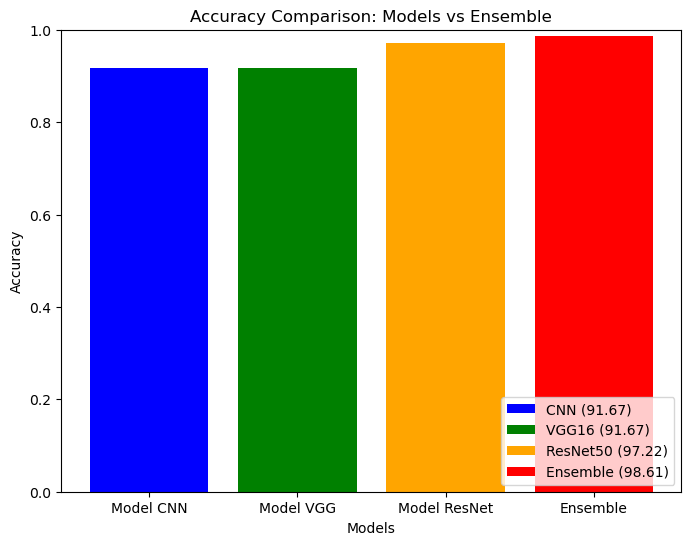

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# Calculate accuracies for individual models
accuracy_model1 = accuracy_score(test_generator.classes, np.argmax(preds_cnn_test, axis=1))
accuracy_model2 = accuracy_score(test_generator.classes, np.argmax(preds_vgg_test, axis=1))
accuracy_model3 = accuracy_score(test_generator.classes, np.argmax(preds_resnet_test, axis=1))
accuracy_ensemble = accuracy  # Ensemble accuracy from your stacked model

# Plot
plt.figure(figsize=(8, 6))

# Plot each bar individually to attach labels for legend
bar1 = plt.bar('Model CNN', accuracy_model1, color='blue', label=f'CNN ({accuracy_model1*100:.2f})')
bar2 = plt.bar('Model VGG', accuracy_model2, color='green', label=f'VGG16 ({accuracy_model2*100:.2f})')
bar3 = plt.bar('Model ResNet', accuracy_model3, color='orange', label=f'ResNet50 ({accuracy_model3*100:.2f})')
bar4 = plt.bar('Ensemble', accuracy_ensemble, color='red', label=f'Ensemble ({accuracy_ensemble*100:.2f})')

# Add value labels
#for bar in [bar1, bar2, bar3, bar4]:
#    yval = bar[0].get_height()
#    plt.text(bar[0].get_x() + bar[0].get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', fontweight='bold')

plt.title('Accuracy Comparison: Models vs Ensemble')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')  # Show legend
plt.show()


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


# Evaluating the CNN Model with Precision, Recall, F1-Score, and Classification Report
## - Converts predicted probabilities to class labels using argmax.
## - Computes and prints accuracy, macro-averaged precision, recall, and F1-score to evaluate the model across all classes.
## - Displays a detailed classification report, including per-class metrics like precision, recall, F1-score, and support.

In [54]:
# Predict probabilities
y_prob = cnn_model.predict(test_generator)

# Get true labels
y_true = test_generator.classes

# Get predicted class labels
y_pred = np.argmax(y_prob, axis=1)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 (macro average for multi-class, or use 'binary' for binary classification)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Classification Report
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(classification_report(y_true, y_pred))



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step 
Precision: 0.92
Recall: 0.92
F1-Score: 0.91
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.80      1.00      0.89        12
           2       1.00      1.00      1.00        12
           3       0.88      0.58      0.70        12
           4       0.86      1.00      0.92        12
           5       1.00      0.92      0.96        12

    accuracy                           0.92        72
   macro avg       0.92      0.92      0.91        72
weighted avg       0.92      0.92      0.91        72



# Evaluating the VGG16 Model with Precision, Recall, F1-Score, and Classification Report
## - Generates predictions from the VGG16 model on the test data.
## - Calculates performance metrics suitable for multi-class classification (macro average).
## - Outputs a detailed classification report with per-class breakdowns.

In [55]:
# Predict probabilities
y_prob = vgg_model.predict(test_generator)

# Get true labels
y_true = test_generator.classes

# Get predicted class labels
y_pred = np.argmax(y_prob, axis=1)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 (macro average for multi-class, or use 'binary' for binary classification)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Classification Report
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(classification_report(y_true, y_pred))



3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Precision: 0.92
Recall: 0.92
F1-Score: 0.92
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.92      0.96        12
           2       0.92      1.00      0.96        12
           3       0.82      0.75      0.78        12
           4       0.79      0.92      0.85        12
           5       1.00      0.92      0.96        12

    accuracy                           0.92        72
   macro avg       0.92      0.92      0.92        72
weighted avg       0.92      0.92      0.92        72



# Evaluating the ResNet50 Model with Precision, Recall, F1-Score, and Classification Report
## - Predicts class probabilities using the ResNet50 model.
## - Calculates performance metrics using macro averaging for fair multi-class evaluation.
## - Outputs a detailed classification report with per-class precision, recall, F1-score, and support.

In [56]:
# Predict probabilities
y_prob = resnet_model.predict(test_generator)

# Get true labels
y_true = test_generator.classes

# Get predicted class labels
y_pred = np.argmax(y_prob, axis=1)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 (macro average for multi-class, or use 'binary' for binary classification)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Classification Report
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(classification_report(y_true, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step
Precision: 0.97
Recall: 0.97
F1-Score: 0.97
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.92      1.00      0.96        12
           2       1.00      0.92      0.96        12
           3       1.00      0.92      0.96        12
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        12

    accuracy                           0.97        72
   macro avg       0.97      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72

